# Transfer Learning using VGG16 and imagenet weights

Checking for GPU in colab...

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
/device:GPU:0
Num GPUs Available:  1


Loading the dataset from drive

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
real = '/content/drive/My Drive/Colab Notebooks/Real_vs_Fake_Face_Kaggle/real_and_fake_face/training_real/'
fake = '/content/drive/My Drive/Colab Notebooks/Real_vs_Fake_Face_Kaggle/real_and_fake_face/training_fake/'

data_path= '/content/drive/My Drive/Colab Notebooks/Real_vs_Fake_Face_Kaggle/real_and_fake_face/'

Visualising the data using matplotlib

In [6]:
import matplotlib.pyplot as plt
import cv2

#Visulaize data
real_data= os.listdir(real)
fake_data= os.listdir(fake)

In [7]:
def load_images_from_folder(path):
    img = cv2.imread(path)
    return img[...,::-1] #converting BGR images from OpenCV to RGB for visualisation

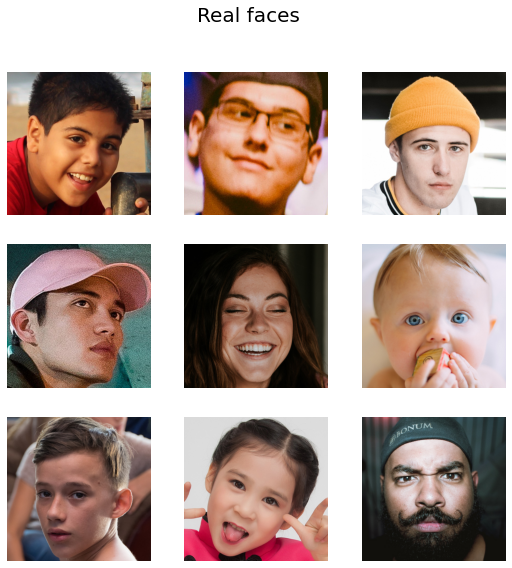

In [8]:
fig = plt.figure(figsize=(9,9))

for i in range (9):
    plt.subplot(3,3,i+1)
    plt.imshow (load_images_from_folder(real+real_data[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')
    
plt.show()


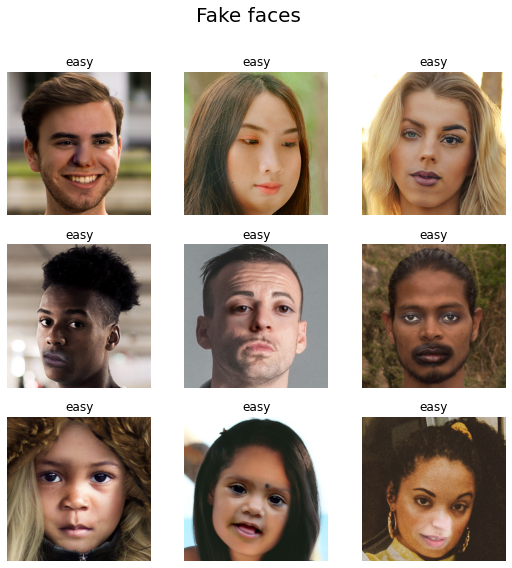

In [9]:
fig = plt.figure(figsize=(9,9))

for i in range (9):
    plt.subplot(3,3,i+1)
    plt.imshow (load_images_from_folder(fake+fake_data[i]), cmap='gray')
    plt.suptitle("Fake faces",fontsize=20)
    plt.title(fake_data[i][:4])
    plt.axis('off')
    
plt.show()

In [10]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image data generator can only split the data into train and validation set.

If test data is need to visualize the output image then use of libraries like use glob and os to split the data into test set.

In this example our main focus is on using transfer learning.

In [11]:
#Augmentation
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [12]:
train_data = image_generator.flow_from_directory(data_path, batch_size= 64,shuffle=True,
                                                 target_size=(224, 224),subset="training",
                                                 class_mode='binary')

Found 1633 images belonging to 2 classes.


In [13]:
val_data = image_generator.flow_from_directory(data_path, batch_size= 64,shuffle=True, target_size=(224, 224),
                                               subset="validation", class_mode='binary')

Found 408 images belonging to 2 classes.


In [14]:
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

Loading VGG16 and build the sequential model in keras

In [15]:
vgg16_model = VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


In [16]:
#setting training layers to false
for layer in vgg16_model.layers:
    layer.trainable=False

In [18]:
model_final = Sequential([vgg16_model, Flatten(),
                          Dense(4096, activation = "relu"),Dropout(0.3),
                          Dense(512, activation = "relu"), Dropout(0.3),                   
                          Dense(2, activation = "softmax")])

In [19]:
model_final.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics="accuracy")

model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [20]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 6:
        return 0.0005
    elif epoch > 6 and epoch <= 20:
        return 0.0001
    else:
        return 0.00005

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [21]:
r = model_final.fit(train_data, validation_data=val_data, epochs=50,callbacks=[lr_callbacks])

Epoch 1/50
26/26 [==============================] - 719s 28s/step - loss: 5.6935 - accuracy: 0.5230 - val_loss: 0.8554 - val_accuracy: 0.5294
Epoch 2/50
26/26 [==============================] - 42s 2s/step - loss: 0.7577 - accuracy: 0.5266 - val_loss: 0.6916 - val_accuracy: 0.5294
Epoch 3/50
26/26 [==============================] - 42s 2s/step - loss: 0.6842 - accuracy: 0.5560 - val_loss: 0.6874 - val_accuracy: 0.5270
Epoch 4/50
26/26 [==============================] - 42s 2s/step - loss: 0.6827 - accuracy: 0.5732 - val_loss: 0.6837 - val_accuracy: 0.5539
Epoch 5/50
26/26 [==============================] - 42s 2s/step - loss: 0.6585 - accuracy: 0.6007 - val_loss: 0.6966 - val_accuracy: 0.5245
Epoch 6/50
26/26 [==============================] - 42s 2s/step - loss: 0.6627 - accuracy: 0.5964 - val_loss: 0.6863 - val_accuracy: 0.5564
Epoch 7/50
26/26 [==============================] - 42s 2s/step - loss: 0.6482 - accuracy: 0.6111 - val_loss: 0.7106 - val_accuracy: 0.5172
Epoch 8/50
26/26 [

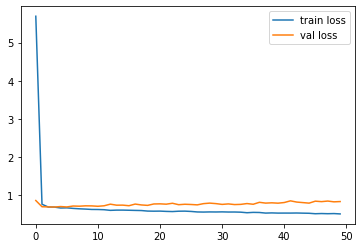

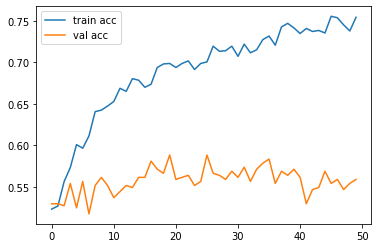

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')